We define the different packages necessary to execute our code

In [172]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np

from SkinDetector import SkinDetector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from SkinDetector import SkinDetector

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout
from keras.layers import Flatten, BatchNormalization
import tensorflow as tf

Here we initialize the "SkinDetector", our previous phase code, that binarizes images detecting skin pixels and setting them to white while the background is set to black. We then process the binarized images and set them to the same size, 480x640, this is necessary because if we do not resize the images, the model will not train them. 
We resize them by creating a new black image, the same colour as our background, and them inserting the white pixels corresponding to the detected skin. We do the same with the test images aswell.
We process the labels too, by setting them to categorical so the model will work correctly. 
(The code executes satisfactorily and the warnings are not a problem)

In [190]:
sd = SkinDetector(dilate=2)
train = sd.segment_dataset(sd.TR_DATA)
train_data = []
for i in range(0,60):
    result = np.zeros((480,640))
    result[:train[i].shape[0],:train[i].shape[1]] = train[i]
    train_data.append(result)
train_data = np.asarray(train_data)
train_labels = np.asarray(sd.TR_LABEL)

test = sd.segment_dataset(sd.VD_DATA)
test_data = []
for i in range(0,test.shape[0]):
    result = np.zeros((480,640))
    result[:test[i].shape[0],:test[i].shape[1]] = test[i]
    test_data.append(result)

test_data = np.asarray(test_data)
test_labels = np.asarray(sd.VD_LABEL)

train_labels2 = np.zeros(len(sd.TR_LABEL))
for it in range (0,len(sd.TR_LABEL)):
    train_labels2[it] = sd.TR_LABEL[it]-1

test_labels2 = np.zeros(len(sd.VD_LABEL))
for it in range (0,len(sd.VD_LABEL)):
    test_labels2[it] = sd.VD_LABEL[it]-1

train_labels = to_categorical(train_labels2)
test_labels = to_categorical(test_labels2)

Here we define our model, as we can see this is a Convolutional based model, with just one convolutional layer, some max pooling and two linear layers at the end to classify into the 6 possible classes (0 fingers to 5 fingers).
The first convolutional layer is taking 4 arguments, the first is the number of filters, 32, the second one is the size of the filters, 3x3, the the size of the images, in our case 480x640 and the "1" to indicate they are binary images. Lastly the activation fucntion, here "relu" stands for a recrtifier function.
Now we perform a pooling operation on the resultant feature maps we get after the convolution is done on an image. The primary aim of a pooling layers is to reduce the size of the images as much as possible, we are trying to reduce the total number of nodes for the upcoming layers. To do this pooling we take a 2x2 matrix, to minimize pixel loss and get a precise region where the feature are located.
The as we can see, we flatten hte pooled images, this is pretty self-explanatory, we just transform the 2D array (pooled images) and converting them to a one dimensional single vector.
The next one we can refer to it as a "hidden layer", just because is between the input and output layers, this is a dense layer which means is fully connected. The parameter 'units' is where we define the number of nodes that should be present in this hidden layers, the number is not optimal but a close approximation to the best one and it is a commin practice to use a power of 2, in this case 128. The activation function will be a recrifier function, the same as the convolutional layer.
Now it is time to initialise our output layer, which should contain 6 nodes, because we have 6 classes. We will be using a sigmoid activation function.

In [199]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3),padding='same',input_shape = (480, 640, 1), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 5, activation = 'sigmoid'))

We now compile the model. We have to say that even though it says that is using a "binary_crossentropy" loss, this is not to worry, because we have 6 classes, so no binary, but the data is transformed in a way that this is the adequate loss function. If we use the "categorical crossentropy" we obtain bad results, because the data is transformed to work with the other one. We just wanted to say this is not a mistake, this is "planned". 
We can also chose the optimizer, in this case "adam" because we tried different ones but they are mostly the same.
Then in "metrics" we chose to display the training accuracy and training recall.

In [200]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.Recall()])

Here we make sure that the labels are correct, and categorically coded.

In [201]:
train_labels.shape

(60, 5)

Here we transform the data to comply with the expected input of the model, the "reshape" seems redundant, but we really resize the images earlier, this is just to sort the dimensions so the model will work as expected.

In [202]:
rows, cols = 480, 640
train_data = train_data.reshape(train_data.shape[0], rows, cols, 1)
test_data = test_data.reshape(test_data.shape[0], rows, cols, 1)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

We make sure the reshape work correctly.

In [203]:
train_data.shape

(60, 480, 640, 1)

Then we train the model, with 20 epochs. ("verbose = 1" is just to display the results as we are training)
Here we want to clarify that we used all of the training images to actually train, because we tried other training methods using a percentatge of images as a validation, usually 10% or 20%, but because we have so few samples, only 60, this reduction on number of training images really affected the results. So is best to train will all the images and not with a validation set. We thought this will lead to overfit, but as the test results can demonstrate, this model is not overfitted.

In [204]:
history = classifier.fit(train_data, train_labels, epochs=20, verbose=1)

Epoch 1/20
60/60 [==============================] - 146s 2s/step - loss: 10.4060 - accuracy: 0.6700 - recall_4: 0.3354
Epoch 2/20
60/60 [==============================] - 190s 3s/step - loss: 8.0232 - accuracy: 0.7933 - recall_4: 0.2328
Epoch 3/20
60/60 [==============================] - 210s 3s/step - loss: 3.1870 - accuracy: 0.7867 - recall_4: 0.4633
Epoch 4/20
60/60 [==============================] - 299s 5s/step - loss: 0.7070 - accuracy: 0.9233 - recall_4: 0.5898
Epoch 5/20
60/60 [==============================] - 332s 6s/step - loss: 0.4067 - accuracy: 0.9500 - recall_4: 0.6447
Epoch 6/20
60/60 [==============================] - 324s 5s/step - loss: 0.3019 - accuracy: 0.9633 - recall_4: 0.6761
Epoch 7/20
60/60 [==============================] - 303s 5s/step - loss: 0.1188 - accuracy: 0.9800 - recall_4: 0.7054
Epoch 8/20
60/60 [==============================] - 197s 3s/step - loss: 0.0312 - accuracy: 0.9967 - recall_4: 0.7391
Epoch 9/20
60/60 [==============================] - 251

Lastly, with the model trained, is time to evaluate it. We do so with the ".evaluate" function of the own model with the "test_dataset" and we get test loss, accuracy and recall.

In [205]:
print('\n# Evaluate on test data')
results = classifier.evaluate(test_data, test_labels)
print('test loss, test acc, test recall:', results)


# Evaluate on test data
45/45 [==============================] - 15s 331ms/step
test loss, test acc, test recall: [5.784291606479221, 0.7644444704055786, 0.8776860237121582]


Here we compute the F1-score as defined in the given project description.

In [206]:
(2*(results[1]*results[2]))/(results[1]+results[2])

0.8171606702176178

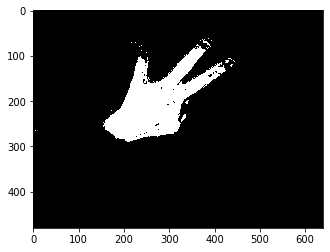

In [168]:
plt.imshow(test2_data[7],cmap='gray')

In [94]:
test[1].shape

(477, 548)

In [123]:
test2_data[1].shape

(480, 640)

In [122]:
test2_data = test_data.reshape(test_data.shape[:-1])

In [171]:
train_labels

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0.

In [177]:
np.asarray(sd.VD_LABEL)

array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2,
       3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4,
       5])

In [188]:
test_labels2 = np.zeros(len(sd.VD_LABEL))
for it in range (0,len(sd.VD_LABEL)):
    test_labels2[it] = sd.VD_LABEL[it]-1
    

In [192]:
train_labels

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0.